In [1]:
# -*- coding:utf-8 -*-
# handwritten digits recognition
# Data: MINIST
# model: resnet
# date: 2021.10.8 14:18

import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# param
batch_size = 100
n_class = 10
padding_size = 15
epoches = 10

In [ ]:
train_dataset = torchvision.datasets.MNIST('./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST('./data/', train=False, transform=transforms.ToTensor(), download=False)
train = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=5)

In [5]:
def gelu(x):
  "Implementation of the gelu activation function by Hugging Face"
  return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [6]:
class ResBlock(nn.Module):
  def __init__(self, in_size, out_size1, out_size2):
    super(ResBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = in_size,
        out_channels = out_size1,
        kernel_size = 3,
        stride = 2,
        padding = padding_size
    )
    self.conv2 = nn.Conv2d(
        in_channels = out_size1,
        out_channels = out_size2,
        kernel_size = 3,
        stride = 2,
        padding = padding_size
    )
    self.batchnorm1 = nn.BatchNorm2d(out_size1)
    self.batchnorm2 = nn.BatchNorm2d(out_size2)
  
  def conv(self, x):
    x = gelu(self.batchnorm1(self.conv1(x)))
    x = gelu(self.batchnorm2(self.conv2(x)))
    return x
  
  def forward(self, x):
    return x + self.conv(x)

In [7]:
# resnet
class Resnet(nn.Module):
  def __init__(self, n_class = n_class):
    super(Resnet, self).__init__()
    self.res1 = ResBlock(1, 8, 16)
    self.res2 = ResBlock(16, 32, 16)
    self.conv = nn.Conv2d(
        in_channels = 16,
        out_channels = n_class,
        kernel_size = 3,
        stride = 2,
        padding = padding_size
    )
    self.batchnorm = nn.BatchNorm2d(n_class)
    self.max_pooling = nn.AdaptiveAvgPool2d(1)

  def forward(self, x):
    x = x.view(-1, 1, 28, 28)
    x = self.res1(x)
    x = self.res2(x)
    x = self.max_pooling(self.batchnorm(self.conv(x)))

    return x.view(x.size(0), -1)


In [11]:
resnet = Resnet().to(device)
resnet

Resnet(
  (res1): ResBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(15, 15))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(15, 15))
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res2): ResBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(15, 15))
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(15, 15))
    (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(15, 15))
  (batchnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pooling): AdaptiveAvgPool2d(output_size=1)
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=resnet.parameters(), lr=1e-2, momentum=0.9)

In [22]:
# train
total_step = len(train)
sum_loss = 0
for epoch in range(epoches):
  for i, (images, targets) in enumerate(train):
    optimizer.zero_grad()
    images = images.to(device)
    targets = targets.to(device)
    preds = resnet(images)
    
    loss = loss_fn(preds, targets)
    sum_loss += loss.item()
    loss.backward()
    optimizer.step()
    if (i+1)%100==0:
      print('[{}|{}] step:{}/{} loss:{:.4f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
  train_curve.append(sum_loss)
  sum_loss = 0
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1|10] step:100/600 loss:0.0104
[1|10] step:200/600 loss:0.0106
[1|10] step:300/600 loss:0.0732
[1|10] step:400/600 loss:0.0317
[1|10] step:500/600 loss:0.1365
[1|10] step:600/600 loss:0.0139
[2|10] step:100/600 loss:0.1351
[2|10] step:200/600 loss:0.0275
[2|10] step:300/600 loss:0.0894
[2|10] step:400/600 loss:0.0616
[2|10] step:500/600 loss:0.0297
[2|10] step:600/600 loss:0.0832
[3|10] step:100/600 loss:0.0885
[3|10] step:200/600 loss:0.0124
[3|10] step:300/600 loss:0.0781
[3|10] step:400/600 loss:0.0477
[3|10] step:500/600 loss:0.0048
[3|10] step:600/600 loss:0.0412
[4|10] step:100/600 loss:0.0146
[4|10] step:200/600 loss:0.0193
[4|10] step:300/600 loss:0.0526
[4|10] step:400/600 loss:0.0025
[4|10] step:500/600 loss:0.0876
[4|10] step:600/600 loss:0.0551
[5|10] step:100/600 loss:0.0240
[5|10] step:200/600 loss:0.0036
[5|10] step:300/600 loss:0.0077
[5|10] step:400/600 loss:0.0169
[5|10] step:500/600 loss:0.0079
[5|10] step:600/600 loss:0.0342
[6|10] step:100/600 loss:0.0029
[6|10] s

In [23]:
# test
resnet.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet(images)
    _, maxIndexes = torch.max(outputs, dim=1)
    correct += (maxIndexes==labels).sum().item()
    total += labels.size(0)
  
  print('in 1w test_data correct rate = {:.4f}'.format((correct/total)*100))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


in 1w test_data correct rate = 98.5100


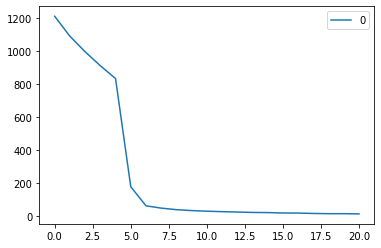

In [24]:
pd.DataFrame(train_curve).plot() # loss曲线